#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried 
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [3]:
#import flights table
flights = pd.read_csv('flights.csv', low_memory=False)
flights.shape

(15927485, 42)

In [49]:
flights.to_pickle('flights.pkl')

In [4]:
# import passengers and fuel consumption tables
passengers = pd.read_csv('passengers.csv')
fuel_consumption = pd.read_csv('fuel_consumption.csv')

In [8]:
avg_delay = flights_sample.groupby(['op_unique_carrier','year','month'])['dep_delay'].mean().reset_index()
avg_delay = avg_delay.groupby('op_unique_carrier')['dep_delay'].mean().reset_index()
delay = deepcopy(avg_delay)


In [9]:
dist = flights_sample.groupby(['op_unique_carrier','year','month'])['distance'].sum().reset_index()
dist = dist.groupby('op_unique_carrier')['distance'].mean().reset_index()


In [10]:
# limit passengers data to just 2018 and 2019 since that is the only data on the flights table
passengers = passengers[passengers['year'] >= 2018]

In [11]:
avg_pass = passengers.groupby(['unique_carrier','year','month'])['passengers'].sum().reset_index()
avg_pass = avg_pass.groupby(['unique_carrier'])['passengers'].mean().reset_index()


In [12]:
# drop NaN carriers and limit data to 2018 and 2019
fuel_consumption = fuel_consumption[fuel_consumption['unique_carrier'].isna() == False]
fuel_consumption = fuel_consumption[fuel_consumption['year'] >= 2018]

In [13]:
avg_fuel = fuel_consumption.groupby(['unique_carrier','year','month'])['total_gallons'].sum().reset_index()
avg_fuel = avg_fuel.groupby('unique_carrier')['total_gallons'].mean().reset_index()


In [14]:
# join data back into main flights table
avg_delay = avg_delay.rename(columns={'op_unique_carrier':'unique_carrier'})
dist = dist.rename(columns={'op_unique_carrier':'unique_carrier'})

df = pd.merge(avg_delay,avg_pass,on='unique_carrier',how='left')
df = pd.merge(df,avg_fuel,on='unique_carrier',how='left')
df = pd.merge(df,dist,on='unique_carrier',how='left')

In [15]:
df['fuel_rate'] = df['total_gallons']/(df['passengers']*df['distance'])

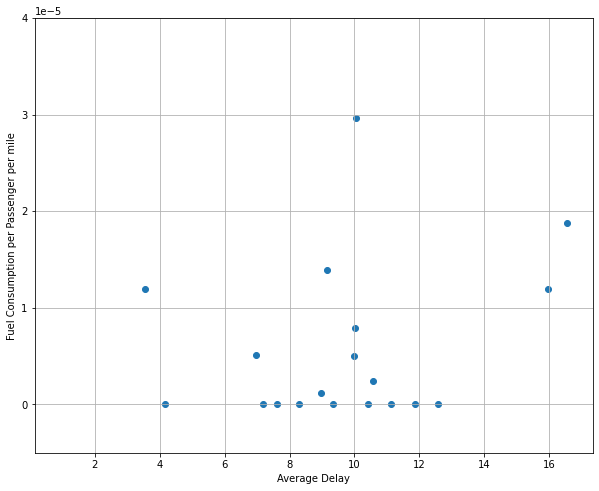

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(df['dep_delay'],df['fuel_rate'])
plt.xlabel('Average Delay')
plt.ylabel('Fuel Consumption per Passenger per mile')
plt.ylim(-0.000005,0.00004)
plt.grid()

In [17]:
total_pass = passengers.groupby('unique_carrier')['passengers'].sum().reset_index()
total_fuel = fuel_consumption.groupby('unique_carrier')['total_gallons'].sum().reset_index()
total_dist = flights_sample.groupby('op_unique_carrier')['distance'].sum().reset_index()

total_fuel = total_fuel[total_fuel['total_gallons']>1]

In [18]:
total_dist = total_dist.rename(columns={'op_unique_carrier':'unique_carrier'})
delay = delay.rename(columns={'op_unique_carrier':'unique_carrier'})

total_df = pd.merge(delay,total_pass,on='unique_carrier',how='left')
total_df = pd.merge(total_df,total_fuel,on='unique_carrier',how='left')
total_df = pd.merge(total_df,total_dist,on='unique_carrier',how='left')

total_df['fuel_rate'] = total_df['total_gallons']/(total_df['passengers']*total_df['distance'])

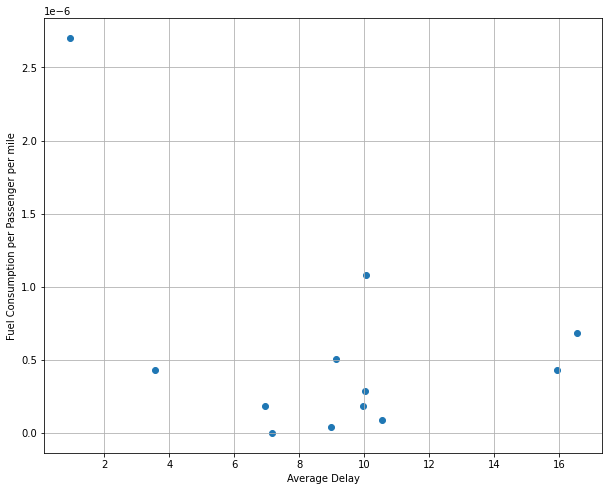

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(total_df['dep_delay'],total_df['fuel_rate'])
plt.xlabel('Average Delay')
plt.ylabel('Fuel Consumption per Passenger per mile')
#plt.ylim(-0.000005,0.00004)
plt.grid()

In [25]:
test_df = deepcopy(total_df)
test_df = test_df[test_df['fuel_rate'].isna()==False]
lower_delay = test_df[test_df['dep_delay']<9.5]
higher_delay = test_df[test_df['dep_delay']>=9.5]


In [26]:
from scipy.stats import ttest_ind

high_delay_mean = np.mean(higher_delay['fuel_rate'])
low_delay_mean = np.mean(lower_delay['fuel_rate'])
print("Higher Delay mean value:",high_delay_mean)
print("Lower Delay mean value:",low_delay_mean)

high_delay_std = np.std(higher_delay['fuel_rate'])
low_delay_std = np.std(lower_delay['fuel_rate'])

print("high delay std value:",high_delay_std)
print("low delay std value:",low_delay_std)

ttest,pval = ttest_ind(higher_delay['fuel_rate'],lower_delay['fuel_rate'])
print("p-value",pval)
if pval <0.05:
  print("Reject null hypothesis")
else:
  print("Accept null hypothesis")

Higher Delay mean value: 4.6026019400717425e-07
Lower Delay mean value: 6.456173084340268e-07
high delay std value: 3.3726599219692925e-07
low delay std value: 9.386407110478222e-07
p-value 0.6865126682405891
Accept null hypothesis


### The values for mean fuel rate between longer delays and shorter delays are not statistically significant

In [27]:
# using more monthly data

In [32]:
flights_sample['year_month'] = str(flights_sample['year'])+str(flights_sample['month'])
flights_sample.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,year,month,year_month
11104347,2018-12-17,WN,WN,WN,1770,WN,N8583Z,1770,11259,DAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,12,11104347 2018\n15145825 2018\n1418949 ...
15145825,2018-02-21,UA,UA,UA,2171,UA,N26215,2171,13930,ORD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2,11104347 2018\n15145825 2018\n1418949 ...
1418949,2019-05-03,UA,UA,UA,977,UA,N33292,977,11618,EWR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,5,11104347 2018\n15145825 2018\n1418949 ...
7708322,2018-03-13,UA,UA,UA,991,UA,N77539,991,11618,EWR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,11104347 2018\n15145825 2018\n1418949 ...
3596121,2019-07-09,WN,WN,WN,2542,WN,N784SW,2542,10693,BNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,11104347 2018\n15145825 2018\n1418949 ...


In [38]:
year_month=[]
for row in range(flights_sample.shape[0]):
    year_month.append(str(flights_sample.iloc[row]['year'])+str(flights_sample.iloc[row]['month']).zfill(2))

In [46]:
year_month_df = pd.DataFrame(year_month,columns=['year_month'])

In [47]:
flights_sample = pd.concat([flights_sample.reset_index(),year_month_df],axis=1)
flights_sample.head()

,index,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,year_month
0,5848953,2019-10-19,AA,AA,AA,1064,AA,N155NN,1064,11298,...,21.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,201812
1,14181612,2018-05-06,WN,WN,WN,3874,WN,N209WN,3874,15304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201802
2,7630489,2018-03-09,DL,DL,DL,1055,DL,N665DN,1055,10397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201905
3,8017372,2018-03-27,NK,NK,NK,529,NK,N615NK,529,14122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201803
4,10416107,2019-11-15,DL,DL,DL,1944,DL,N6700,1944,10397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201907


In [48]:
monthly_summary = flights_sample.groupby(['op_unique_carrier','year_month'],as_index=False).agg({'distance':'sum','dep_delay':'mean'})